In [1]:
import numpy as np
from env import BlackJackEnv, deck_sum
from tqdm import tqdm

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

In [2]:
def draw_wireframe(data):
    x = y = np.arange(0, 10)
    x, y = np.meshgrid(x, y)
    z = data[0][:][:]
    fig = plt.figure(figsize=(30, 4))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.view_init(elev=35,azim=-80)
    ax.plot_wireframe(x, y, z, rstride=1, cstride=1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.view_init(elev=35,azim=-80)
    z = data[1][:][:]
    ax.plot_wireframe(x, y, z, rstride=1, cstride=1)

    plt.show()

def dealer_policy(deck):
    s, u = deck_sum(deck)
    if s >= 17:
        act = 'stick'
    else:
        act = 'hit'
    return act

def player_policy(deck):
    s, u = deck_sum(deck)
    if s == 20 or s == 21:
        act = 'stick'
    else:
        act = 'hit'
    return act

### First-visit MC prediction, for estimating $V \approx v_\pi$

In a Blackjack game, there are three variables for the player to consider:
- Current sum of the cards, obviously only the range (12-21) should be considered, since if the sum is less or equal to 11, the player should always hit.
- The dealer's one showing card, which can be valued in the range of ace to 10 (numerically we can consider the ace as 1).
- Whether or not he holds a usable ace, binary-valued variable.

Thus we can use an array of shape (2, 10, 10) as our state-value function, for the convenience of random access.

In [3]:
env = BlackJackEnv(dealer_policy=dealer_policy)

Deck initialized, please call `reset()` to start dealing.


 20%|█▉        | 98470/500000 [00:06<00:26, 15087.01it/s]

Episode: 99999


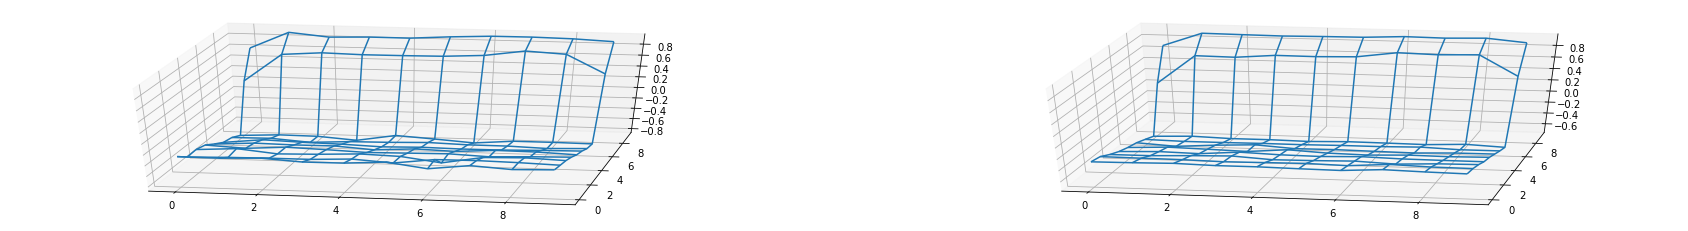

 40%|███▉      | 198845/500000 [00:14<00:25, 11978.08it/s]

Episode: 199999


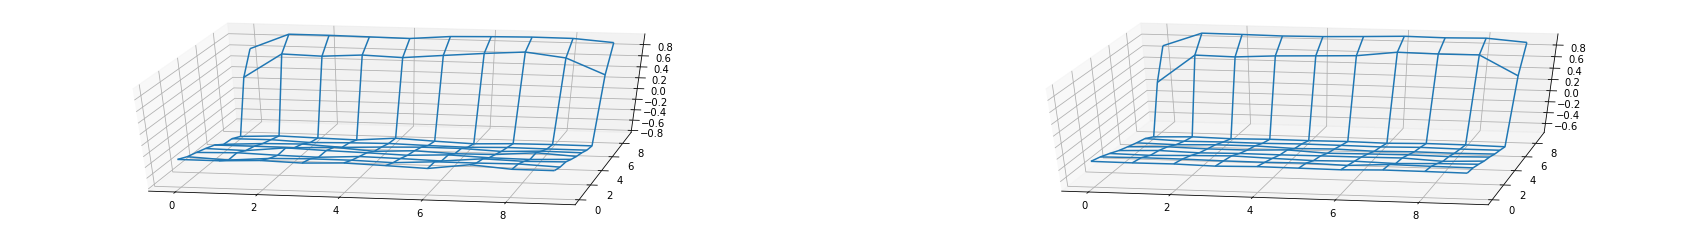

 60%|█████▉    | 299549/500000 [00:23<00:16, 11917.34it/s]

Episode: 299999


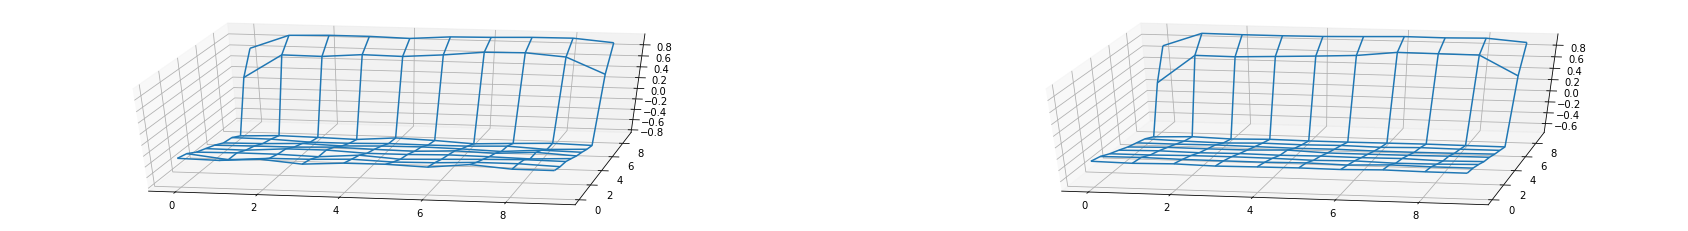

 80%|███████▉  | 398906/500000 [00:30<00:07, 13227.03it/s]

Episode: 399999


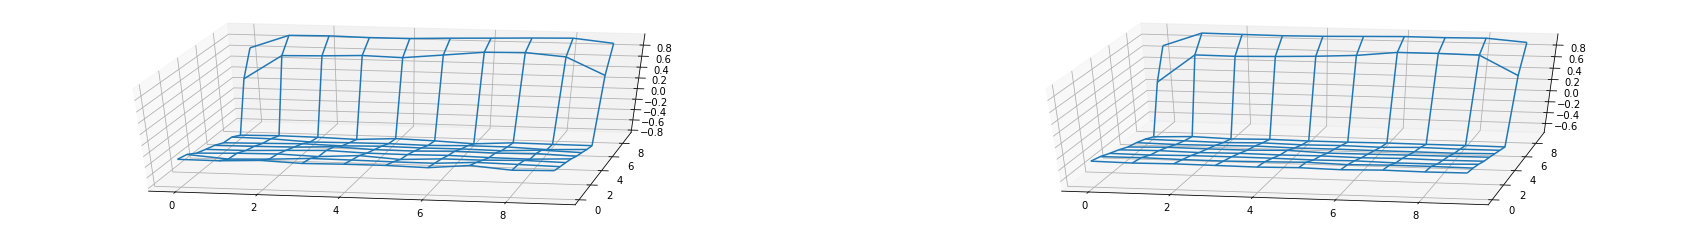

100%|█████████▉| 499499/500000 [00:38<00:00, 12509.85it/s]

Episode: 499999


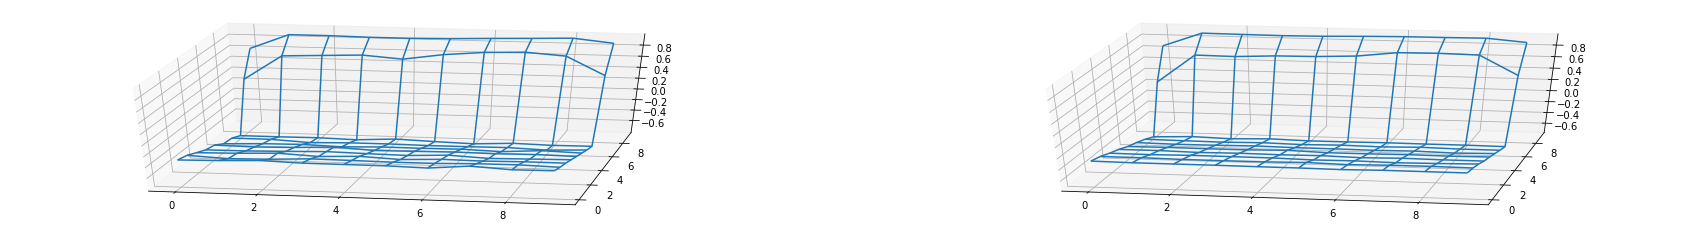

100%|██████████| 500000/500000 [00:38<00:00, 12871.32it/s]


In [4]:
state_value = np.random.random(size=(2, 10, 10))
num_episodes = 500000
gamma = 1.0
all_seen_states = np.zeros(shape=state_value.shape)
for i in tqdm(range(num_episodes)):
    gain = 0
    # Run an episode
    obs = env.reset()
    seen_state = np.zeros(shape=state_value.shape) # Add 1 if appeared in current episode.
    while True:
        player_sum, dealer_deck, usable_ace = env.numerical_state
        action = player_policy(obs['player_deck'])
        next_obs, reward, done, _ = env.step(action)
        gain = gamma * gain + reward
        if player_sum >=12 and player_sum <=21: # Intersted state
            player_sum -= 12
            usable_ace = int(usable_ace)
            dealer_deck -= 1
            if not seen_state[usable_ace][player_sum][dealer_deck]:
                seen_state[usable_ace][player_sum][dealer_deck] = 1
                seen_num = all_seen_states[usable_ace][player_sum][dealer_deck]
                old_state_value = state_value[usable_ace][player_sum][dealer_deck]
                state_value[usable_ace][player_sum][dealer_deck] = (old_state_value * seen_num + gain) / (seen_num + 1)
        if done:
            obs = env.reset()
            break
        else:
            obs = next_obs
    if (i+1) % 100000 == 0:
        print("Episode: {}".format(i))
        draw_wireframe(state_value)
    all_seen_states += seen_state

### Every-visit MC prediction

 20%|█▉        | 99789/500000 [00:09<00:34, 11510.57it/s]

Episode: 99999


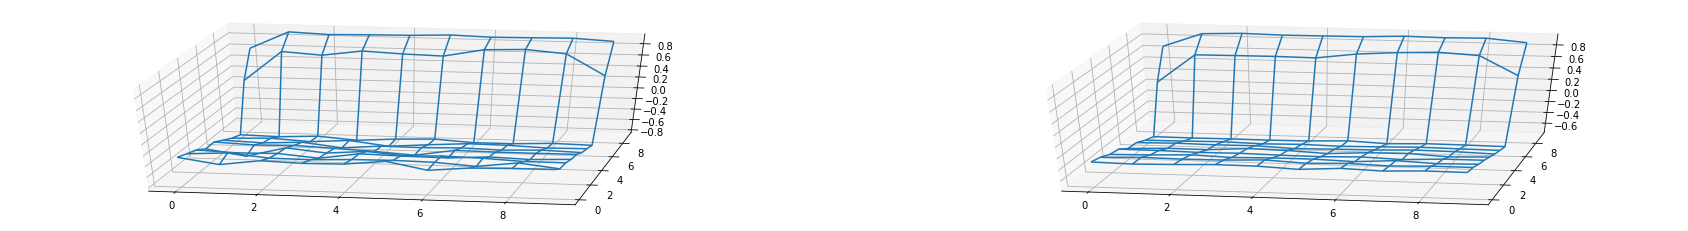

 40%|███▉      | 199847/500000 [00:21<00:45, 6657.17it/s] 

Episode: 199999


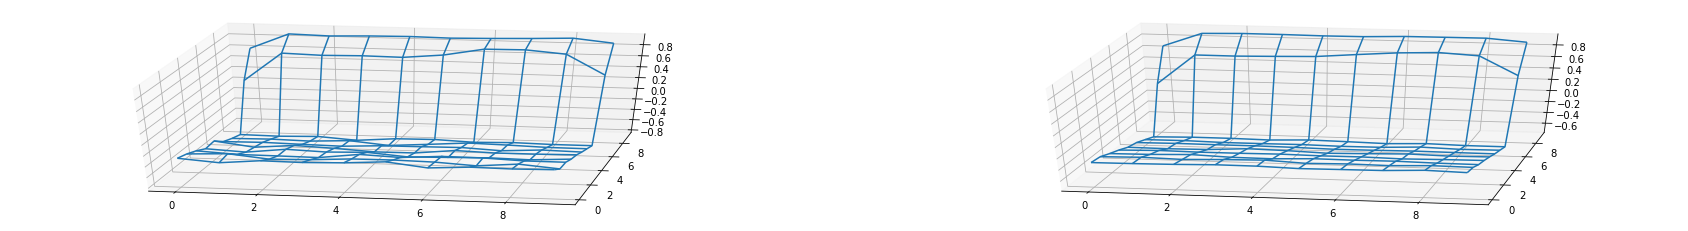

 60%|█████▉    | 299761/500000 [00:32<00:20, 9585.54it/s] 

Episode: 299999


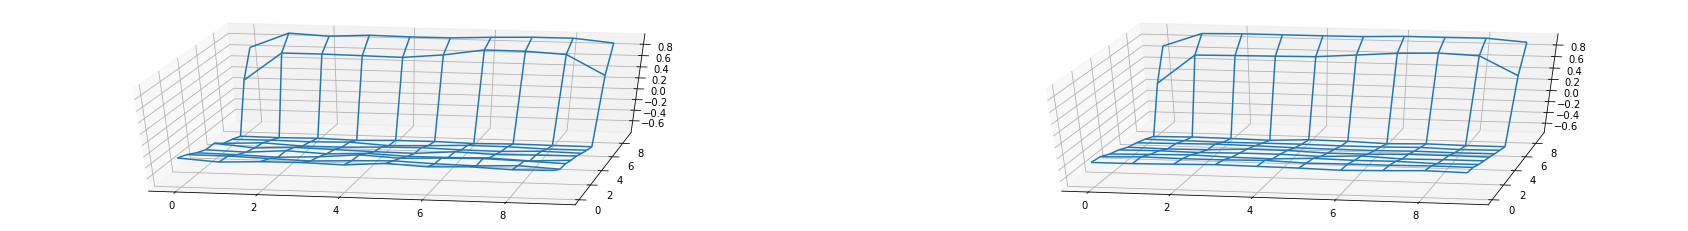

 80%|███████▉  | 398998/500000 [00:42<00:11, 8878.77it/s] 

Episode: 399999


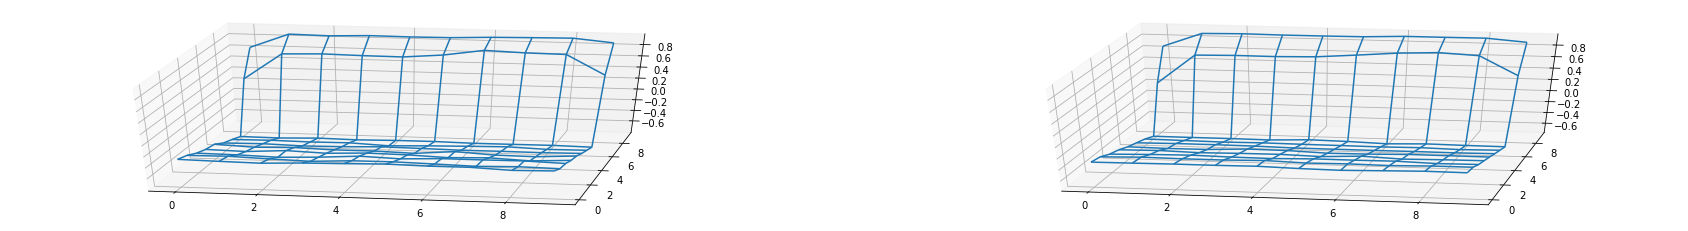

100%|█████████▉| 499125/500000 [00:52<00:00, 10860.14it/s]

Episode: 499999


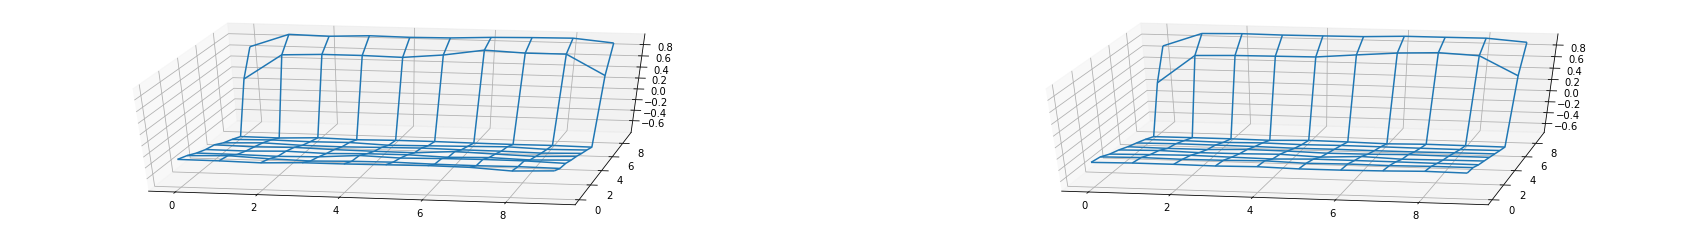

100%|██████████| 500000/500000 [00:52<00:00, 9446.91it/s] 


In [5]:
state_value = np.random.random(size=(2, 10, 10))
num_episodes = 500000
gamma = 1.0
all_seen_states = np.zeros(shape=state_value.shape)
for i in tqdm(range(num_episodes)):
    gain = 0
    # Run an episode
    obs = env.reset()
    seen_state = np.zeros(shape=state_value.shape) # Add 1 if appeared in current episode.
    while True:
        player_sum, dealer_deck, usable_ace = env.numerical_state
        action = player_policy(obs['player_deck'])
        next_obs, reward, done, _ = env.step(action)
        gain = gamma * gain + reward
        if player_sum >=12 and player_sum <=21: # Intersted state
            player_sum -= 12
            usable_ace = int(usable_ace)
            dealer_deck -= 1
            seen_state[usable_ace][player_sum][dealer_deck] += 1
            seen_num = all_seen_states[usable_ace][player_sum][dealer_deck]
            old_state_value = state_value[usable_ace][player_sum][dealer_deck]
            state_value[usable_ace][player_sum][dealer_deck] = (old_state_value * seen_num + gain) / (seen_num + 1)
        if done:
            obs = env.reset()
            break
        else:
            obs = next_obs
    if (i+1) % 100000 == 0:
        print("Episode: {}".format(i))
        draw_wireframe(state_value)
    all_seen_states += seen_state